In [2]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import uniform_filter1d
from scipy.io import loadmat
import re
from sklearn.metrics import roc_curve, roc_auc_score

In [204]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize lists for training and validation images
train_img_list = []
val_img_list = []
val_metadata = []

# Load and process training images
train_img_paths = list(Path("/kaggle/input/dataset/UCSDped2/Train").rglob("*.tif"))  # Get all .tif files recursively
for img_path in train_img_paths:
    img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED)
    img = cv.resize(img, (235, 155))  # Resize image
    train_img_list.append(img)

train_images_np = np.array(train_img_list)  # Convert to numpy array

# Load and process validation images
val_dirs = [d for d in Path("/kaggle/input/dataset/UCSDped2/Test").iterdir() if d.is_dir() and not d.name.endswith("gt")]
for val_dir in val_dirs:
    val_img_files = list(val_dir.glob("*.tif"))  # Get all .tif files in the directory
    val_metadata.append((str(val_dir), len(val_img_files)))
    for img_path in val_img_files:
        img = cv.imread(str(img_path), cv.IMREAD_UNCHANGED)
        img = cv.resize(img, (235, 155))  # Resize image
        val_img_list.append(img)

val_images_np = np.array(val_img_list)

train_metadata=[]
train_dirs=[d for d in Path("/kaggle/input/dataset/UCSDped2/Train").iterdir()]
for train_dir in train_dirs:
    train_metadata.append((str(train_dir.name),len(list(train_dir.glob("*.tif")))))


In [157]:
def create_edge_tensor(image):
    # Apply Canny edge detection
    edge = cv.Canny(image, 100, 200)
    
    # Normalize the result to the range [-1, 1]
    return torch.tensor((edge / 255.0) * 2 - 1,dtype=torch.float32)


def create_optical_flow(image,next_image):
   
    flow = cv.calcOpticalFlowFarneback(image, next_image, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Compute the magnitude of the flow at each pixel
    flow_magnitude = np.sqrt(flow[:,:,0]**2 + flow[:,:,1]**2) 
    return  torch.tensor(cv.normalize(flow_magnitude, None, -1, 1, cv.NORM_MINMAX),dtype=torch.float32)
        


    

In [106]:
optical_train = []
optical_val = []
aux_train = np.array([])
aux_val = np.array([])

# For validation data
aux = 0
for val_data in val_metadata:
    folder_name, num_images = val_data
    start_idx = aux
    end_idx = aux + num_images - 1
    for i in range(start_idx, end_idx):
        # Assuming `val_images[i]` and `val_images[i+1]` are frames in the dataset
        optical_val.append(create_optical_flow(val_img_list[i], val_img_list[i+1]))

    aux += num_images


# For train data
aux = 0
for train_data in train_metadata:
    folder_name, num_images = train_data
    start_idx = aux
    end_idx = aux + num_images - 1

    for i in range(start_idx, end_idx):
        optical_train.append(create_optical_flow(train_img_list[i], train_img_list[i+1]))

    aux += num_images



In [107]:
val_metadata = sorted([(Path(path).name[-3:], count) for path, count in val_metadata if count != 0])

print(val_metadata)

# Read ground truth file
gt_file_path = Path("/kaggle/input/dataset/UCSDped2/Test/UCSDped2.m")  # Ensure it's a valid path
with gt_file_path.open('r') as file:
    lines = file.readlines()
gt=[]
for i in range(1,len(lines)):
    line=lines[i].split(" ")[-1]
    nrs = re.split(r'[ \[\]:]+', line)
    start, finish=int(nrs[1]),int(nrs[2])
    gt.append([0]*val_metadata[i-1][1])
    print(len([0]*val_metadata[i-1][1]))
    gt[i-1][start-1:finish]=[1] * (finish - start + 1)

print(val_metadata)

[('001', 180), ('002', 180), ('003', 150), ('004', 180), ('005', 150), ('006', 180), ('007', 180), ('008', 180), ('009', 120), ('010', 150), ('011', 180), ('012', 180)]
180
180
150
180
150
180
180
180
120
150
180
180
[('001', 180), ('002', 180), ('003', 150), ('004', 180), ('005', 150), ('006', 180), ('007', 180), ('008', 180), ('009', 120), ('010', 150), ('011', 180), ('012', 180)]


In [465]:
class CAE(nn.Module):
    def __init__(self, in_channels):
        super(CAE, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=in_channels, kernel_size=15, stride=4)
        self._initialize_weights()

    def forward(self, x):
        # Encoder
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.tanh(self.conv3(x))

        # Decoder
        x = torch.tanh(self.deconv1(x))
        x = self.upsample1(x)
        x = torch.tanh(self.deconv2(x))
        x = self.upsample2(x)
        x = torch.tanh(self.deconv3(x))
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                init.xavier_uniform_(module.weight)  # Xavier Uniform Initialization
                if module.bias is not None:
                    init.zeros_(module.bias)


# class CAE(nn.Module):
#     def __init__(self, in_channels):
#         super(CAE, self).__init__()

#         # Encoder (2 Convolutional Layers)
#         self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=11, stride=4, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)

#         # Decoder (2 Transposed Convolution Layers)
#         self.deconv1 = nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=1, stride=1)
#         self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.deconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=in_channels, kernel_size=17, stride=4, padding=1)

#         self._initialize_weights()

#     def forward(self, x):
#         # Encoder
#         x = torch.tanh(self.conv1(x))
#         x = self.pool1(x)
#         x = torch.tanh(self.conv2(x))

#         # Decoder
#         x = torch.tanh(self.deconv1(x))
#         x = self.upsample1(x)
#         x = torch.tanh(self.deconv2(x))
#         return x

#     def _initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
#                 nn.init.xavier_uniform_(module.weight)  # Xavier Uniform Initialization
#                 if module.bias is not None:
#                     nn.init.zeros_(module.bias)

# class CAE(nn.Module):
#     def __init__(self, in_channels):
#         super(CAE, self).__init__()

#         # Encoder (2 Convolutional Layers)
#         self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=256, kernel_size=11, stride=2, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2)
#         self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1, stride=1)
#         self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=2)

#         # Decoder
#         self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=1, stride=1)
#         self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
#         self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
#         self.deconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
#         self.deconv4 = nn.ConvTranspose2d(in_channels=256, out_channels=in_channels, kernel_size=21, stride=4,padding=1)

#     def forward(self, x):
#         # Encoder
#         #print(f"Input shape: {x.shape}")
#         x = torch.tanh(self.conv1(x))
#         #print(f"After conv1: {x.shape}")
#         x = self.pool1(x)
#         #print(f"After pool1: {x.shape}")
#         x = torch.tanh(self.conv2(x))
#         #print(f"After conv2: {x.shape}")
#         x = self.pool2(x)
#         #print(f"After pool2: {x.shape}")
#         x = torch.tanh(self.conv3(x))
#         #print(f'After conv3:{x.shape} ')
#         x = torch.tanh(self.conv4(x))
#         #print(f'After conv4:{x.shape} ')

#         # Decoder
#         x = torch.tanh(self.deconv1(x))
#         #print(f"After deconv1: {x.shape}")
#         x = self.upsample1(x)
#         #print(f"After upsample1: {x.shape}")
#         x = torch.tanh(self.deconv2(x))
#         #print(f"After deconv2: {x.shape}")
#         x = self.deconv3(x)
#         #print(f"After deconv3: {x.shape}")
#         x = self.deconv4(x)
#         #print(f"After deconv4: {x.shape}")
#         return x

#     def _initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
#                 nn.init.xavier_uniform_(module.weight)  # Xavier Uniform Initialization
#                 if module.bias is not None:
#                     nn.init.zeros_(module.bias)



class CustomData(Dataset):
    def __init__(self, images, bool_edge=0, bool_optical_flow=0, optical_images=[]):
        self.images = images
        self.bool_edge = bool_edge   
        self.bool_optical_flow = bool_optical_flow
        self.optical_images = optical_images

    def __len__(self):
        return len(self.images)

    def normalize_image(self, image):
        image_tensor = torch.tensor(image, dtype=torch.float32)
        image_tensor = image_tensor / 255.0  # Normalize to [0, 1]
        return 2 * image_tensor - 1  # Convert to [-1, 1]

    def __getitem__(self, idx):
        image_tensor = self.normalize_image(self.images[idx])
        inputs = []
        targets = []
        inputs.append(image_tensor)
        targets.append(image_tensor)

        # Depending on the flags, return different combinations of inputs
        if self.bool_edge == 1:
            edge_tensor = create_edge_tensor(self.images[idx])
            inputs.append(edge_tensor)
            targets.append(edge_tensor)

        if self.bool_optical_flow == 1:
            optical_image = self.optical_images[idx]
            inputs.append(optical_image)
            targets.append(optical_image)

        inputs_tensor = torch.stack(inputs, dim=0)  # Stack along the channel dimension (dim=0)
        targets_tensor = torch.stack(targets, dim=0)  # Stack along the channel dimension (dim=0)
    

        

        return inputs_tensor, targets_tensor



def compute_per_pixel_reconstruction_error(input_frame, reconstructed_frame):
    input_frame = input_frame.cpu().numpy()
    reconstructed_frame = reconstructed_frame.cpu().numpy()

    pixel_differences = input_frame - reconstructed_frame
    pixel_errors = np.sqrt(pixel_differences**2)
    return pixel_errors

def compute_frame_reconstruction_error(pixel_errors):
    return np.sum(pixel_errors)

def smooth_fre(fre_values, window_size):
    smooth = []
    for i in range(len(fre_values) - window_size):
        smooth.append(sum(fre_values[i:i+window_size]) / window_size)
    for i in range(len(fre_values) - window_size, len(fre_values)):
        smooth.append(sum(fre_values[i:]) / (len(fre_values) - i))
    return smooth

def compute_rre(smoothed_fre, min_val, max_val):
    smoothed_fre = np.array(smoothed_fre)
    return (smoothed_fre - min_val) / (max_val - min_val)

In [434]:
# Example configuration dictionary
case_study_config = {
    'FR': {'bool_edge': 0, 'bool_optical_flow': 0,'in_channels':1},
    'FR+ED': {'bool_edge': 1, 'bool_optical_flow': 0,'in_channels':2},
    'FR+OF': {'bool_edge': 0, 'bool_optical_flow': 1,'in_channels':2},
    'FR+ED+OF': {'bool_edge': 1, 'bool_optical_flow': 1,'in_channels':3}
}

In [435]:
cumulative_train=[0]
cumulative_val=[0]
running_sum = 0
for i, (folder_name, num_images) in enumerate(train_metadata):
    running_sum += num_images
    cumulative_train.append(running_sum)

running_sum = 0
for i, (folder_name, num_images) in enumerate(val_metadata):
    running_sum += num_images
    cumulative_val.append(running_sum)

cumulative_val=cumulative_val[:len(cumulative_val)-1]
cumulative_train=cumulative_train[:len(cumulative_train)-1]

In [412]:
print(cumulative_val)

[0, 180, 360, 540, 690, 870, 1020, 1200, 1320, 1500, 1680, 1830]


In [445]:
def train_case_study(case_study_name, train_data, val_data, device):
    best_model_path = f"best_model4_{case_study_name}.pth"  
    if case_study_name == 'FR+OF' or case_study_name == 'FR+ED+OF':
        train_data = np.delete(train_data, cumulative_train, axis=0)
        val_data = np.delete(val_data, cumulative_val, axis=0)
    print(train_data.shape)
    print(np.array(optical_train).shape)
    print(val_data.shape)
    print(np.array(optical_val).shape)
    case_config = case_study_config.get(case_study_name, None)
    bool_edge = case_config['bool_edge']
    bool_optical_flow = case_config['bool_optical_flow']
    print(f"Edge: {bool_edge}, Optical Flow: {bool_optical_flow}")
    
    in_channels = bool_edge + bool_optical_flow + 1  # Always 1 channel for the frame
    print(f"Number of input channels: {in_channels}")
    
    # Initialize the datasets
    train_dataset = CustomData(train_data, bool_edge=bool_edge, bool_optical_flow=bool_optical_flow, optical_images=optical_train)
    val_dataset = CustomData(val_data, bool_edge=bool_edge, bool_optical_flow=bool_optical_flow, optical_images=optical_val)
    
    # Initialize the DataLoader
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=120, shuffle=False)

    model = CAE(in_channels=in_channels).to(device)
    optimizer = optim.Adagrad(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    best_val_metric = float('inf')
    
    epochs = 30
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        # Training loop
        for inputs, targets in train_loader:
            inputs = inputs.to(device)  # Since inputs is now already stacked along the channel dimension
            targets=targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        epoch_loss_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)  # Since inputs is now already stacked along the channel dimension
                targets=targets.to(device)
                
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_loss_val += loss.item()
        
        avg_loss_val = epoch_loss_val / len(val_loader)
        print(f"{case_study_name} - Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Loss_val: {avg_loss_val:.4f}")
        
        # Save best model
        if avg_loss_val < best_val_metric:
            best_val_metric = avg_loss_val
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved for {case_study_name} at epoch {epoch+1} with val_metric: {best_val_metric:.4f}")
    
    print(f"Training complete for {case_study_name}!")


In [452]:
import torch.optim as optim
import torch.nn.init as init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for case_name in case_studies_train.keys():
    if case_name=='FR' or case_name=='FR+ED':
        continue
    train_case_study(case_name, train_images_np, val_images_np,device)

(2534, 155, 235)
(2534, 155, 235)
(1998, 155, 235)
(1998, 155, 235)
Edge: 0, Optical Flow: 1
Number of input channels: 2
FR+OF - Epoch [1/30], Loss: 0.1118, Loss_val: 0.0551
Best model saved for FR+OF at epoch 1 with val_metric: 0.0551
FR+OF - Epoch [2/30], Loss: 0.0409, Loss_val: 0.0408
Best model saved for FR+OF at epoch 2 with val_metric: 0.0408
FR+OF - Epoch [3/30], Loss: 0.0370, Loss_val: 0.0396
Best model saved for FR+OF at epoch 3 with val_metric: 0.0396
FR+OF - Epoch [4/30], Loss: 0.0342, Loss_val: 0.0391
Best model saved for FR+OF at epoch 4 with val_metric: 0.0391
FR+OF - Epoch [5/30], Loss: 0.0323, Loss_val: 0.0365
Best model saved for FR+OF at epoch 5 with val_metric: 0.0365
FR+OF - Epoch [6/30], Loss: 0.0305, Loss_val: 0.0325
Best model saved for FR+OF at epoch 6 with val_metric: 0.0325
FR+OF - Epoch [7/30], Loss: 0.0288, Loss_val: 0.0306
Best model saved for FR+OF at epoch 7 with val_metric: 0.0306
FR+OF - Epoch [8/30], Loss: 0.0275, Loss_val: 0.0295
Best model saved for 

In [267]:
print(val_images_np.shape)

(2010, 155, 235)


In [453]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn.init as init
from sklearn.metrics import roc_auc_score, roc_curve




# Initialize storage for evaluation results
results4 = {}

for case_study_name in case_studies_train.keys():
    print(f"\nEvaluating Case Study: {case_study_name}")
    model_path=f"best_model4_{case_study_name}.pth"
    case_config = case_study_config.get(case_study_name, None)
    bool_edge = case_config['bool_edge']
    bool_optical_flow = case_config['bool_optical_flow']
    in_channels = bool_edge + bool_optical_flow + 1
    model=CAE(in_channels=in_channels).to(device)
    print(model_path)
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()

    if case_study_name == 'FR+OF' or case_study_name == 'FR+ED+OF':
        val_data = np.delete(val_images_np, cumulative_val, axis=0)
        val_data = np.squeeze(val_data)
    else:
        val_data=val_images_np


    # Load validation data for the current case study
    val_dataset = CustomData(val_data, bool_edge=bool_edge, bool_optical_flow=bool_optical_flow, optical_images=optical_val)
    val_loader = DataLoader(val_dataset, batch_size=120, shuffle=False)

    total_smooth_val = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            outputs=model(inputs)            
            all_pixel_errors = [
                compute_per_pixel_reconstruction_error(inputs[i], outputs[i])
                for i in range(len(inputs))
            ]
            # Compute frame reconstruction errors
            fre_values = [compute_frame_reconstruction_error(pixel_errors) for pixel_errors in all_pixel_errors]

            # Smooth the frame reconstruction errors
            smoothed_fre = smooth_fre(np.array(fre_values), window_size=5)
            total_smooth_val.extend(smoothed_fre)

    # Normalize using min and max values
    total_smooth_val = np.array(total_smooth_val)
    rre_values_val = compute_rre(total_smooth_val, min(total_smooth_val), max(total_smooth_val))
    print(len(rre_values_val))

    if case_study_name=='FR+OF' or case_study_name=='FR+ED+OF':
        flattened_gt = [nr for l in gt for nr in l[1:]]
    else:
        flattened_gt = [nr for l in gt for nr in l]  # Flatten ground truth
    
    print(len(flattened_gt))
    auc = roc_auc_score(flattened_gt, rre_values_val)

    # Compute EER
    fpr, tpr, thresholds = roc_curve(flattened_gt, rre_values_val)
    fnr = 1 - tpr
    eer_threshold_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_threshold_index]
    eer_threshold = thresholds[eer_threshold_index]

    print(f"AUC: {auc:.4f}")
    print(f"EER: {eer:.4f} at Threshold: {eer_threshold:.4f}")

    # Store results for later comparison
    results4[case_study_name] = {"AUC": auc, "EER": eer, "Threshold": eer_threshold}

# Print summary of results
print("\nFinal Evaluation Results:")
for case_study_name, metrics in results3.items():
    print(f"{case_study_name}: AUC = {metrics['AUC']:.4f}, EER = {metrics['EER']:.4f} at Threshold {metrics['Threshold']:.4f}")



Evaluating Case Study: FR
best_model4_FR.pth
2010
2010
AUC: 0.5999
EER: 0.4530 at Threshold: 0.5379

Evaluating Case Study: FR+ED
best_model4_FR+ED.pth
2010
2010
AUC: 0.6309
EER: 0.4254 at Threshold: 0.4847

Evaluating Case Study: FR+OF
best_model4_FR+OF.pth
1998
1998
AUC: 0.5777
EER: 0.4510 at Threshold: 0.5208

Evaluating Case Study: FR+ED+OF
best_model4_FR+ED+OF.pth
1998
1998
AUC: 0.6279
EER: 0.4146 at Threshold: 0.3683

Final Evaluation Results:
FR: AUC = 0.5932, EER = 0.4613 at Threshold 0.5132
FR+ED: AUC = 0.6325, EER = 0.4309 at Threshold 0.4759
FR+OF: AUC = 0.5410, EER = 0.4790 at Threshold 0.5805
FR+ED+OF: AUC = 0.6232, EER = 0.4202 at Threshold 0.4091


In [320]:
print(len(gt[1]))

180


In [31]:
print(case_studies_val['FR+ED'][1].shape) 

(155, 235, 2)



Processing case: FR


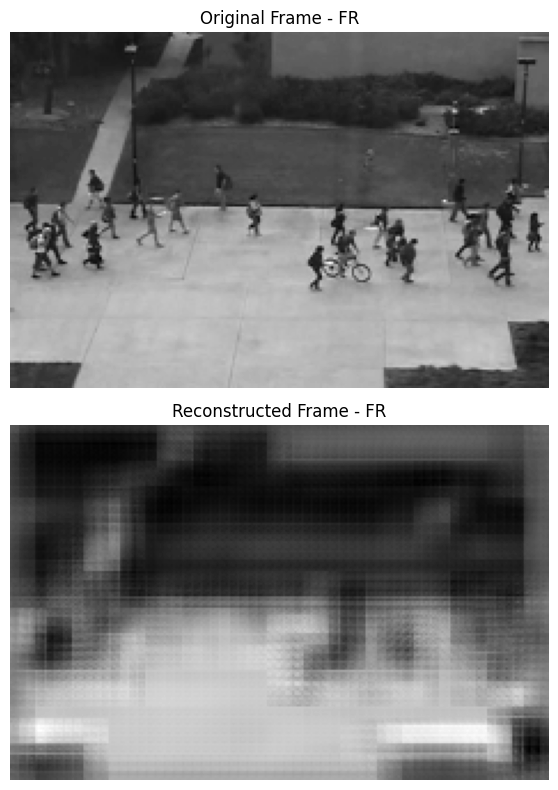


Processing case: FR+ED


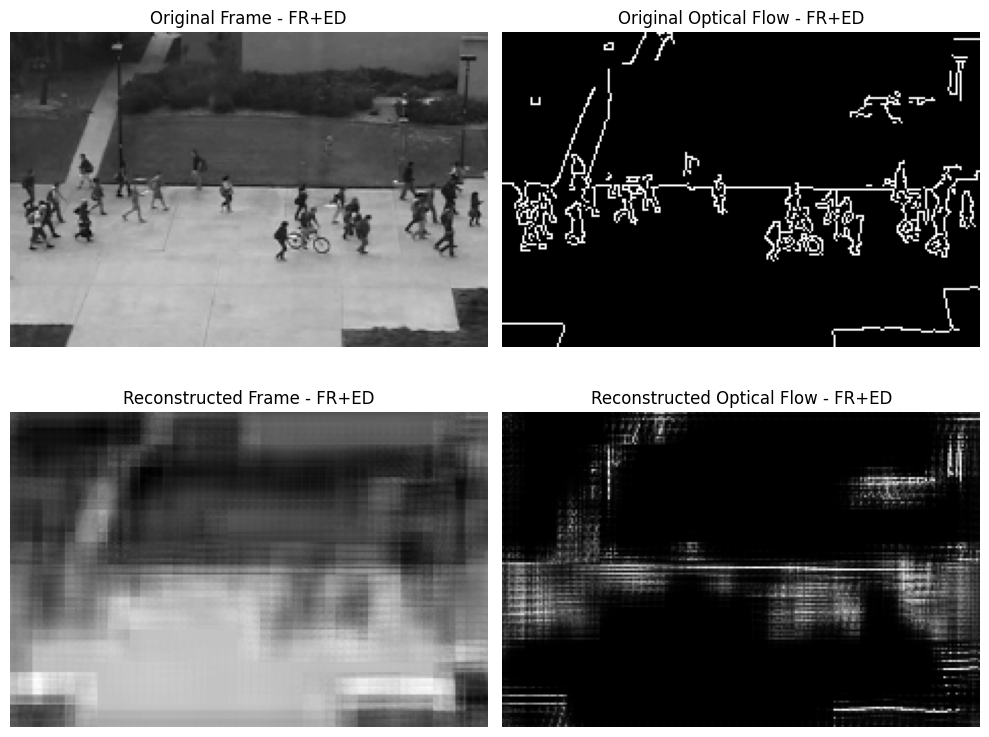


Processing case: FR+OF


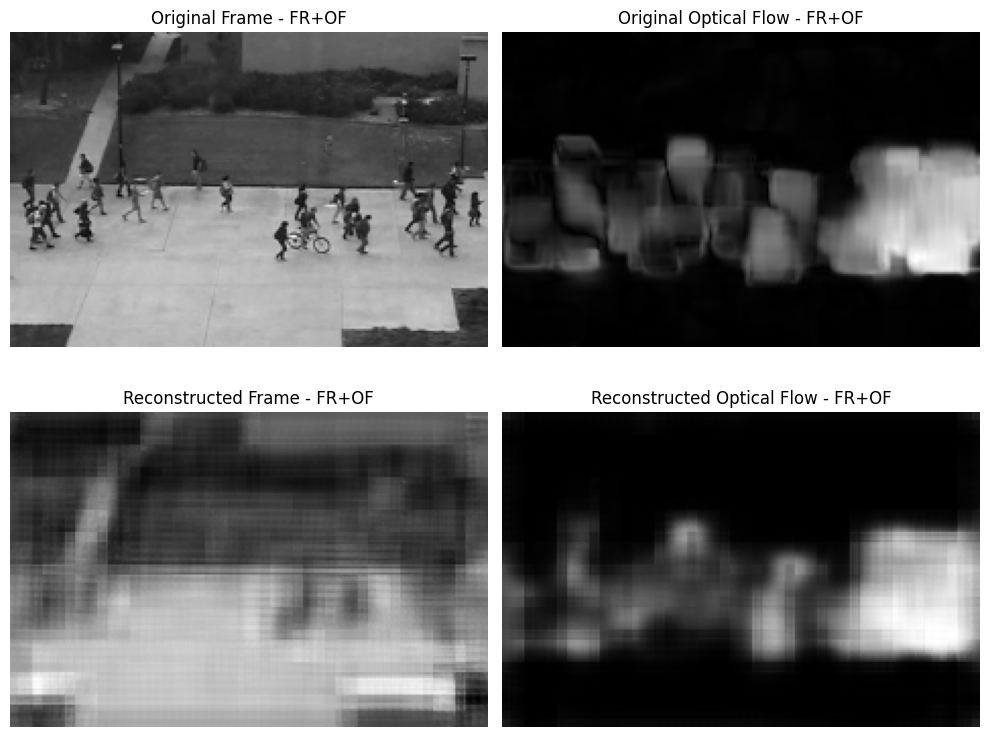


Processing case: FR+ED+OF


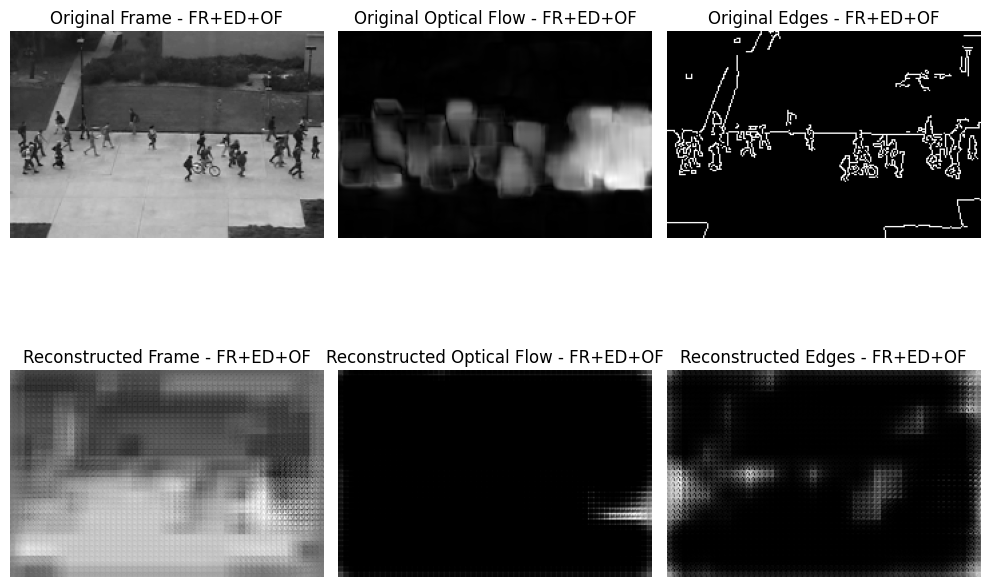

In [466]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the four case studies with their configurations
case_studies = {
    "FR": {"use_edges": False, "use_optical_flow": False, "channels": 1},
    "FR+ED": {"use_edges": True, "use_optical_flow": False, "channels": 2},
    "FR+OF": {"use_edges": False, "use_optical_flow": True, "channels": 2},
    "FR+ED+OF": {"use_edges": True, "use_optical_flow": True, "channels": 3},
}

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume val_images_np[0] contains the original frame
frame1 = val_images_np[100].astype(np.float32)  # Shape: (H, W)

# Normalize to [-1, 1]
frame1 = 2 * (frame1 / 255.0) - 1

# Function to generate the input tensor
def preprocess_inputs(frame1, case_config):
    input_tensors = [torch.tensor(frame1, dtype=torch.float32).unsqueeze(0)]  # Start with the frame tensor

    # If optical flow is required, assume val_images_np[1] is frame2
    if case_config["use_optical_flow"]:
        frame2 = val_images_np[101].astype(np.float32)  # Load second frame
        flow = cv2.calcOpticalFlowFarneback(val_images_np[100].astype(np.float32), frame2, None, pyr_scale=0.5, levels=3, winsize=15,
                                            iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
        magnitude = np.sqrt(flow[..., 0] ** 2 + flow[..., 1] ** 2)
        magnitude = magnitude.astype(np.float32)
        magnitude = 2 * (magnitude / np.max(magnitude)) - 1
        input_tensors.append(torch.tensor(magnitude, dtype=torch.float32).unsqueeze(0))

    # If edges are required, apply Canny edge detection
    if case_config["use_edges"]:
        edges = cv2.Canny(val_images_np[100], 100, 200)
        edges = edges.astype(np.float32) / 255.0
        edges = 2 * edges - 1
        input_tensors.append(torch.tensor(edges, dtype=torch.float32).unsqueeze(0))

    # Stack inputs and return
    input_tensor = torch.cat(input_tensors, dim=0).unsqueeze(0).to(device)
    return input_tensor

# Loop through each case study
for case, config in case_studies.items():
    print(f"\nProcessing case: {case}")

    # Load the correct model
    model = CAE(in_channels=config["channels"])  # Adjust in_channels based on inputs
    model.load_state_dict(torch.load(f"best_model_{case}.pth", map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    # Preprocess the input
    input_tensor = preprocess_inputs(frame1, config)

    # Forward pass through the model
    with torch.no_grad():
        output = model(input_tensor)

    # Convert tensors to NumPy for visualization
    input_tensor = input_tensor.cpu().numpy().squeeze(0)  # Remove batch dimension
    output = output.cpu().numpy().squeeze(0)  # Remove batch dimension

    # Ensure shape consistency (handle grayscale)
    if input_tensor.ndim == 2:
        input_tensor = np.expand_dims(input_tensor, axis=0)
    if output.ndim == 2:
        output = np.expand_dims(output, axis=0)

    num_channels = input_tensor.shape[0]  # Number of input channels

    # Plot results
    fig, axes = plt.subplots(2, num_channels, figsize=(10, 8))

    # If only 1 channel, avoid indexing with (0, i)
    if num_channels == 1:
        axes[0].imshow((input_tensor[0] + 1) / 2, cmap="gray")
        axes[0].set_title(f"Original Frame - {case}")
        axes[0].axis("off")

        axes[1].imshow((output[0] + 1) / 2, cmap="gray")
        axes[1].set_title(f"Reconstructed Frame - {case}")
        axes[1].axis("off")

    else:
        titles = ["Frame", "Optical Flow", "Edges"][:num_channels]  # Adjust based on available channels
        for i in range(num_channels):
            axes[0, i].imshow((input_tensor[i] + 1) / 2, cmap="gray")
            axes[0, i].set_title(f"Original {titles[i]} - {case}")
            axes[0, i].axis("off")

            axes[1, i].imshow((output[i] + 1) / 2, cmap="gray")
            axes[1, i].set_title(f"Reconstructed {titles[i]} - {case}")
            axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


NameError: name 'results1' is not defined

In [454]:
print(results)
print(results2)
print(results3)
print(results4)


{'FR': {'AUC': 0.6040638577482165, 'EER': 0.430939226519337, 'Threshold': 0.557734076317259}, 'FR+ED': {'AUC': 0.6275445207316419, 'EER': 0.4198895027624309, 'Threshold': 0.46763878785703944}, 'FR+OF': {'AUC': 0.5757761971333323, 'EER': 0.45098039215686275, 'Threshold': 0.4757608555917783}, 'FR+ED+OF': {'AUC': 0.6510684712641912, 'EER': 0.3949579831932773, 'Threshold': 0.36829372630585194}}
{'FR': {'AUC': 0.595877138872499, 'EER': 0.4696132596685083, 'Threshold': 0.5224735039427033}, 'FR+ED': {'AUC': 0.6345528482540364, 'EER': 0.430939226519337, 'Threshold': 0.45076262528390687}, 'FR+OF': {'AUC': 0.5732328275612499, 'EER': 0.4649859943977591, 'Threshold': 0.4693995741528161}, 'FR+ED+OF': {'AUC': 0.6246635156195324, 'EER': 0.4425770308123249, 'Threshold': 0.4162172585401533}}
{'FR': {'AUC': 0.5932169581076008, 'EER': 0.4613259668508287, 'Threshold': 0.513199311546441}, 'FR+ED': {'AUC': 0.6324810250496165, 'EER': 0.430939226519337, 'Threshold': 0.47586414567631763}, 'FR+OF': {'AUC': 0.54